# 1. Mô tả

Ở notebook này chúng ta sẽ có 3 bước chính:

1. Xây dựng class Logistic Regression bằng Numpy.

2. Huấn luyện trên hai hypotheses.

3. Đánh giá mô hình

    - Cài đặt các hàm tính metrics (như insight ở notebook 01, chúng ta nên đánh giá bằng F1-score)

    - Nhận xét kết quả

## Import thư viện

In [3]:
# import các thư viện cần thiết

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Cấu hình hiển thị
sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore")

## Cài đặt lớp Logistic Regression và khai báo hàm cần thiết

In [4]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Hàm sigmoid ổn định số (tránh overflow khi exp).

    Input:
        z (np.ndarray): mảng (n,) hoặc (n, d) hoặc scalar
    Output:
        np.ndarray: sigmoid(z), cùng shape với z
    """
    z = np.asarray(z, dtype=float)

    out = np.empty_like(z, dtype=float)
    pos_mask = z >= 0

    # z >= 0: 1 / (1 + exp(-z)) an toàn
    out[pos_mask] = 1.0 / (1.0 + np.exp(-z[pos_mask]))

    # z < 0: exp(z) / (1 + exp(z)) an toàn hơn exp(-z)
    exp_z = np.exp(z[~pos_mask])
    out[~pos_mask] = exp_z / (1.0 + exp_z)

    return out


def add_intercept(X: np.ndarray) -> np.ndarray:
    """
    Thêm cột bias (1) vào đầu ma trận X.

    Input:
        X (np.ndarray): shape (n_samples, n_features)
    Output:
        np.ndarray: shape (n_samples, n_features + 1), cột 0 toàn 1
    """
    X = np.asarray(X, dtype=float)
    ones = np.ones((X.shape[0], 1), dtype=float)
    return np.hstack([ones, X])


def binary_cross_entropy(y_true: np.ndarray, y_prob: np.ndarray, eps: float = 1e-12) -> float:
    """
    Tính Binary Cross Entropy (log loss) cho bài toán nhị phân.

    Input:
        y_true (np.ndarray): nhãn thật, shape (n,), giá trị 0/1
        y_prob (np.ndarray): xác suất dự đoán P(y=1|x), shape (n,), trong [0,1]
        eps (float): hằng số nhỏ để tránh log(0)
    Output:
        float: giá trị loss trung bình
    """
    y_true = np.asarray(y_true, dtype=float).reshape(-1)
    y_prob = np.asarray(y_prob, dtype=float).reshape(-1)

    y_prob = np.clip(y_prob, eps, 1.0 - eps)
    loss = -(y_true * np.log(y_prob) + (1.0 - y_true) * np.log(1.0 - y_prob))
    return float(np.mean(loss))


def standardize_fit(X_train: np.ndarray, eps: float = 1e-8) -> tuple[np.ndarray, np.ndarray]:
    """
    Fit tham số chuẩn hoá (z-score) trên train: mean và std theo từng cột.

    Input:
        X_train (np.ndarray): shape (n_train, n_features)
        eps (float): tránh chia cho 0 nếu std quá nhỏ
    Output:
        (mu, sigma):
            mu (np.ndarray): mean theo cột, shape (n_features,)
            sigma (np.ndarray): std theo cột, shape (n_features,)
    """
    X_train = np.asarray(X_train, dtype=float)
    mu = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis=0)

    # nếu sigma quá nhỏ thì set = 1 để khỏi chia cho 0
    sigma = np.where(sigma < eps, 1.0, sigma)
    return mu, sigma


def standardize_transform(X: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """
    Transform chuẩn hoá z-score: (X - mu) / sigma.

    Input:
        X (np.ndarray): shape (n_samples, n_features)
        mu (np.ndarray): mean theo cột
        sigma (np.ndarray): std theo cột
    Output:
        np.ndarray: X đã chuẩn hoá
    """
    X = np.asarray(X, dtype=float)
    return (X - mu) / sigma


def standardize_train_valid_test(
    X_train: np.ndarray,
    X_valid: np.ndarray | None = None,
    X_test: np.ndarray | None = None
) -> tuple[np.ndarray, np.ndarray | None, np.ndarray | None, np.ndarray, np.ndarray]:
    """
    Chuẩn hoá theo train, rồi áp dụng cho valid/test (nếu có).

    Input:
        X_train (np.ndarray): train features
        X_valid (np.ndarray | None): valid features
        X_test (np.ndarray | None): test features
    Output:
        (X_train_s, X_valid_s, X_test_s, mu, sigma)
    """
    mu, sigma = standardize_fit(X_train)
    X_train_s = standardize_transform(X_train, mu, sigma)

    X_valid_s = None if X_valid is None else standardize_transform(X_valid, mu, sigma)
    X_test_s = None if X_test is None else standardize_transform(X_test, mu, sigma)

    return X_train_s, X_valid_s, X_test_s, mu, sigma


class LogisticRegressionNumpy:
    """
    Logistic Regression (Binary) cài đặt bằng NumPy, tối ưu bằng Gradient Descent.

    Ý tưởng:
        p = sigmoid(Xw)
        loss = Binary Cross Entropy (+ L2 nếu có)
        w <- w - lr * grad

    Lưu ý:
        - Nên chuẩn hoá feature trước khi fit (z-score) để hội tụ ổn định hơn.
        - y nên là {0,1}.
    """

    def __init__(
        self,
        lr: float = 0.1,
        n_iters: int = 2000,
        fit_intercept: bool = True,
        reg_lambda: float = 0.0,
        tol: float = 1e-7,
        verbose: bool = False
    ):
        """
        Input:
            lr (float): learning rate
            n_iters (int): số vòng lặp gradient descent
            fit_intercept (bool): nếu True thì tự thêm cột bias
            reg_lambda (float): hệ số L2 (0.0 = không regularization)
            tol (float): ngưỡng dừng sớm theo cải thiện loss
            verbose (bool): nếu True thì in loss định kỳ
        """
        self.lr = float(lr)
        self.n_iters = int(n_iters)
        self.fit_intercept = bool(fit_intercept)
        self.reg_lambda = float(reg_lambda)
        self.tol = float(tol)
        self.verbose = bool(verbose)

        self.w_ = None
        self.loss_history_ = []

    def _prepare_X(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("X phải có shape (n_samples, n_features)")
        if self.fit_intercept:
            X = add_intercept(X)
        return X

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LogisticRegressionNumpy":
        """
        Huấn luyện mô hình.

        Input:
            X (np.ndarray): features, shape (n_samples, n_features)
            y (np.ndarray): nhãn, shape (n_samples,), giá trị 0/1
        Output:
            self: trả về chính object để chain
        """
        Xp = self._prepare_X(X)
        y = np.asarray(y, dtype=float).reshape(-1)

        if Xp.shape[0] != y.shape[0]:
            raise ValueError("Số dòng của X và y không khớp")

        n_samples, n_features = Xp.shape

        # init weight = 0
        self.w_ = np.zeros(n_features, dtype=float)
        self.loss_history_ = []

        prev_loss = np.inf

        for i in range(self.n_iters):
            logits = Xp @ self.w_
            y_prob = sigmoid(logits)

            # gradient BCE
            grad = (Xp.T @ (y_prob - y)) / n_samples

            # L2 regularization (không regularize intercept)
            if self.reg_lambda > 0.0:
                w_reg = self.w_.copy()
                if self.fit_intercept:
                    w_reg[0] = 0.0
                grad += (self.reg_lambda / n_samples) * w_reg

            # update
            self.w_ -= self.lr * grad

            # theo dõi loss
            loss = binary_cross_entropy(y, y_prob)
            if self.reg_lambda > 0.0:
                w_reg2 = self.w_.copy()
                if self.fit_intercept:
                    w_reg2[0] = 0.0
                loss += (self.reg_lambda / (2.0 * n_samples)) * float(np.sum(w_reg2 ** 2))

            self.loss_history_.append(loss)

            # dừng sớm nếu cải thiện rất nhỏ
            if abs(prev_loss - loss) < self.tol:
                if self.verbose:
                    print(f"Early stop tại iter={i}, loss={loss:.6f}")
                break

            prev_loss = loss

            if self.verbose and (i % 200 == 0):
                print(f"iter={i:4d} | loss={loss:.6f}")

        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Dự đoán xác suất P(y=1|x).

        Input:
            X (np.ndarray): shape (n_samples, n_features)
        Output:
            np.ndarray: shape (n_samples,), giá trị trong [0,1]
        """
        if self.w_ is None:
            raise ValueError("Model chưa fit. Hãy gọi fit() trước.")

        Xp = self._prepare_X(X)
        return sigmoid(Xp @ self.w_)

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Dự đoán nhãn 0/1 theo ngưỡng threshold.

        Input:
            X (np.ndarray): shape (n_samples, n_features)
            threshold (float): ngưỡng phân loại (mặc định 0.5)
        Output:
            np.ndarray: shape (n_samples,), giá trị 0 hoặc 1
        """
        prob = self.predict_proba(X)
        return (prob >= threshold).astype(int)

In [5]:
def load_modeling_csv(file_path: str) -> tuple[np.ndarray, np.ndarray, list]:
    """
    Load file modeling dạng CSV (đã được export từ notebook 02).

    Quy ước file:
        - Có header ở dòng đầu
        - Cột cuối cùng là target (Attrition_Flag)
        - Các cột còn lại là feature

    Input:
        file_path (str): đường dẫn tới file CSV (ví dụ ../data/modeling/h1_train.csv)

    Output:
        X (np.ndarray): shape (n_samples, n_features), dtype float
        y (np.ndarray): shape (n_samples,), dtype int (0/1)
        feature_names (list): danh sách tên feature (không gồm target)
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Không tìm thấy file: {file_path}")

    with open(file_path, "r", encoding="utf-8") as f:
        header = f.readline().strip().split(",")

    data = np.genfromtxt(file_path, delimiter=",", skip_header=1, dtype=float)

    if data.ndim == 1:
        data = data.reshape(1, -1)

    X = data[:, :-1]
    y = data[:, -1].astype(int)

    feature_names = header[:-1]
    return X, y, feature_names


In [7]:
def confusion_counts(y_true: np.ndarray, y_pred: np.ndarray) -> tuple[int, int, int, int]:
    """
    Tính TP, FP, TN, FN cho bài toán nhị phân.

    Input:
        y_true (np.ndarray): shape (n,), nhãn thật (0/1)
        y_pred (np.ndarray): shape (n,), nhãn dự đoán (0/1)

    Output:
        (tp, fp, tn, fn): 4 số nguyên
    """
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    y_pred = np.asarray(y_pred).astype(int).reshape(-1)

    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    return tp, fp, tn, fn


def precision_recall_f1(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-12) -> tuple[float, float, float]:
    """
    Tính Precision, Recall, F1-score.

    Input:
        y_true (np.ndarray): shape (n,), nhãn thật (0/1)
        y_pred (np.ndarray): shape (n,), nhãn dự đoán (0/1)
        eps (float): tránh chia cho 0

    Output:
        (precision, recall, f1): bộ 3 float
    """
    tp, fp, tn, fn = confusion_counts(y_true, y_pred)

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    return float(precision), float(recall), float(f1)

In [13]:
def evaluate_binary_classifier(
    model: LogisticRegressionNumpy,
    X: np.ndarray,
    y: np.ndarray,
    threshold: float = 0.5,
    name: str = "Dataset",
    plot_cm: bool = True
) -> dict:
    """
    Đánh giá mô hình nhị phân theo threshold và (tuỳ chọn) vẽ confusion matrix.

    Input:
        model (LogisticRegressionNumpy): model đã fit
        X (np.ndarray): features, shape (n_samples, n_features)
        y (np.ndarray): nhãn thật, shape (n_samples,), giá trị 0/1
        threshold (float): ngưỡng dự đoán
        name (str): tên tập để in ra
        plot_cm (bool): nếu True thì vẽ confusion matrix bằng heatmap

    Output:
        dict: chứa accuracy, precision, recall, f1, tp/fp/tn/fn
    """
    y = np.asarray(y).astype(int).reshape(-1)

    prob = model.predict_proba(X)
    pred = (prob >= threshold).astype(int)

    tp, fp, tn, fn = confusion_counts(y, pred)

    acc = float(np.mean(pred == y))
    precision, recall, f1 = precision_recall_f1(y, pred)

    print(f"\n[{name}] threshold={threshold}")
    print("Accuracy :", acc)
    print("Precision:", precision)
    print("Recall   :", recall)
    print("F1-score :", f1)

    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)

    if plot_cm:
        plt.figure(figsize=(4.8, 3.8))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            linewidths=0.5,
            linecolor="white"
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.xticks([0.5, 1.5], ["0", "1"])
        plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Confusion matrix (TN FP / FN TP):")
        print(cm)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp, "fp": fp, "tn": tn, "fn": fn
    }

In [18]:
def print_logistic_hypothesis(
    model: LogisticRegressionNumpy,
    feature_names: list[str],
    mu: np.ndarray | None = None,
    sigma: np.ndarray | None = None,
    name: str = "H2"
) -> None:
    """
    In ra hàm giả thuyết cho Logistic Regression.

    Nếu có chuẩn hoá:
        x̃_i = (x_i - mu_i) / sigma_i
        z(x) = b + Σ w_i * x̃_i
        p(y=1|x) = sigmoid(z(x))
    """
    if model.w_ is None:
        raise ValueError("Model chưa fit nên chưa có trọng số w_.")

    w = np.asarray(model.w_, dtype=float)

    if model.fit_intercept:
        b = w[0]
        coef = w[1:]
    else:
        b = 0.0
        coef = w

    if len(coef) != len(feature_names):
        raise ValueError("Số hệ số và số feature không khớp.")

    print(f"\n[{name}] Hàm giả thuyết")
    if (mu is not None) and (sigma is not None):
        mu = np.asarray(mu, dtype=float).reshape(-1)
        sigma = np.asarray(sigma, dtype=float).reshape(-1)

        print("Gọi x̃_i = (x_i - mu_i) / sigma_i (chuẩn hoá theo train)")
        terms = [f"({b:.6f})"]
        for c, fname in zip(coef, feature_names):
            terms.append(f"({c:.6f}) * x̃_{fname}")
        z_expr = " + ".join(terms)

        print("z(x) = " + z_expr)
        print("p(y=1|x) = sigmoid(z(x))")

        print("\nChi tiết x̃ theo từng feature:")
        for fname, m, s in zip(feature_names, mu, sigma):
            print(f"- x̃_{fname} = ({fname} - {m:.6f}) / {s:.6f}")

    else:
        terms = [f"({b:.6f})"]
        for c, fname in zip(coef, feature_names):
            terms.append(f"({c:.6f}) * {fname}")
        z_expr = " + ".join(terms)

        print("z(x) = " + z_expr)
        print("p(y=1|x) = sigmoid(z(x))")

    print("\nTrọng số đã học:")
    print(f"- intercept (b) = {b:.6f}")
    for fname, c in zip(feature_names, coef):
        print(f"- w_{fname} = {c:.6f}")

# 2. Huấn luyện mô hình

## 2.1. Giả thuyết 1

### Load dữ liệu

In [6]:
# Load H1 datasets
h1_train_path = "../data/modeling/h1_train.csv"
h1_valid_path = "../data/modeling/h1_valid.csv"
h1_test_path  = "../data/modeling/h1_test.csv"

X_train_h1, y_train_h1, h1_feature_names = load_modeling_csv(h1_train_path)
X_valid_h1, y_valid_h1, _ = load_modeling_csv(h1_valid_path)
X_test_h1,  y_test_h1,  _ = load_modeling_csv(h1_test_path)

print("H1 feature names:", h1_feature_names)
print("Train:", X_train_h1.shape, y_train_h1.shape, "| churn rate:", y_train_h1.mean())
print("Valid:", X_valid_h1.shape, y_valid_h1.shape, "| churn rate:", y_valid_h1.mean())
print("Test : ", X_test_h1.shape,  y_test_h1.shape,  "| churn rate:", y_test_h1.mean())

H1 feature names: ['Total_Trans_Ct', 'Total_Revolving_Bal', 'Contacts_Count_12_mon']
Train: (8103, 3) (8103,) | churn rate: 0.16092805133901025
Valid: (1012, 3) (1012,) | churn rate: 0.15810276679841898
Test :  (1012, 3) (1012,) | churn rate: 0.16106719367588934


### Hyperparameters tuning

In [9]:
# 1) Chuẩn hoá dữ liệu (fit theo train, apply cho valid/test)
X_train_h1_s, X_valid_h1_s, X_test_h1_s, mu_h1, sigma_h1 = standardize_train_valid_test(
    X_train_h1, X_valid_h1, X_test_h1
)

print("Đã chuẩn hoá xong cho H1.")
print("Train mean:", np.mean(X_train_h1_s, axis=0))
print("Train std:", np.std(X_train_h1_s, axis=0))


# 2) Grid search learning rate + threshold theo F1 trên VALID
lr_grid = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
threshold_grid = np.linspace(0.10, 0.90, 81)

best = {
    "lr": None,
    "threshold": None,
    "f1": -1.0,
    "precision": None,
    "recall": None
}

for lr in lr_grid:
    model = LogisticRegressionNumpy(
        lr=lr,
        n_iters=3000,
        fit_intercept=True,
        reg_lambda=0.0,
        tol=1e-7,
        verbose=False
    )
    model.fit(X_train_h1_s, y_train_h1)

    valid_prob = model.predict_proba(X_valid_h1_s)

    for th in threshold_grid:
        valid_pred = (valid_prob >= th).astype(int)
        p, r, f1 = precision_recall_f1(y_valid_h1, valid_pred)

        if f1 > best["f1"]:
            best["lr"] = lr
            best["threshold"] = float(th)
            best["f1"] = f1
            best["precision"] = p
            best["recall"] = r

print("\nBest hyperparameters cho H1 (theo VALID F1):")
print("- best_lr:", best["lr"])
print("- best_threshold:", best["threshold"])
print("- precision:", best["precision"])
print("- recall:", best["recall"])
print("- f1:", best["f1"])

# lưu lại để dùng cho bước Fit + Evaluation
best_lr_h1 = best["lr"]
best_threshold_h1 = best["threshold"]

Đã chuẩn hoá xong cho H1.
Train mean: [-8.86753476e-17  1.39719848e-16  6.45307713e-16]
Train std: [1. 1. 1.]

Best hyperparameters cho H1 (theo VALID F1):
- best_lr: 0.003
- best_threshold: 0.37
- precision: 0.5549132947976847
- recall: 0.5999999999999963
- f1: 0.5765765765760739


### Fit mô hình

Best lr (H1): 0.003
Best threshold (H1): 0.37
H1 training done.
Số iter thực tế: 5000
Loss cuối: 0.3375665749271994

[H1] Hàm giả thuyết
Gọi x̃_i = (x_i - mu_i) / sigma_i (chuẩn hoá theo train)
z(x) = (-1.677863) + (-0.759380) * x̃_Total_Trans_Ct + (-0.506249) * x̃_Total_Revolving_Bal + (0.333007) * x̃_Contacts_Count_12_mon
p(y=1|x) = sigmoid(z(x))

Chi tiết x̃ theo từng feature:
- x̃_Total_Trans_Ct = (Total_Trans_Ct - 64.765519) / 23.393833
- x̃_Total_Revolving_Bal = (Total_Revolving_Bal - 1165.408491) / 817.588312
- x̃_Contacts_Count_12_mon = (Contacts_Count_12_mon - 2.455263) / 1.096567

Trọng số đã học:
- intercept (b) = -1.677863
- w_Total_Trans_Ct = -0.759380
- w_Total_Revolving_Bal = -0.506249
- w_Contacts_Count_12_mon = 0.333007


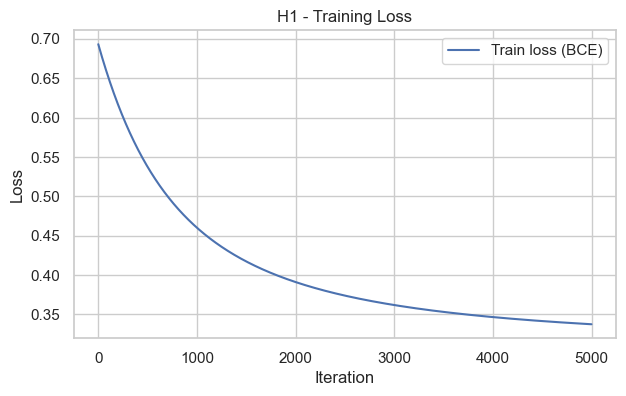

In [19]:
# Fit H1 model với best_lr_h1 (đã tuning theo VALID F1)
print("Best lr (H1):", best_lr_h1)
print("Best threshold (H1):", best_threshold_h1)

model_h1 = LogisticRegressionNumpy(
    lr=best_lr_h1,
    n_iters=5000,
    fit_intercept=True,
    reg_lambda=0.0,
    tol=1e-7,
    verbose=False
)

model_h1.fit(X_train_h1_s, y_train_h1)

print("H1 training done.")
print("Số iter thực tế:", len(model_h1.loss_history_))
print("Loss cuối:", model_h1.loss_history_[-1])

print_logistic_hypothesis(
    model_h1,
    feature_names=h1_feature_names,
    mu=mu_h1,
    sigma=sigma_h1,
    name="H1"
)

# Vẽ loss history để xem có giảm đều không
plt.figure(figsize=(7, 4))
plt.plot(model_h1.loss_history_, label="Train loss (BCE)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("H1 - Training Loss")
plt.legend()
plt.show()

### Số liệu đánh giá


[H1 - Train] threshold=0.37
Accuracy : 0.866222386770332
Precision: 0.5930626057529607
Recall   : 0.537576687116564
F1-score : 0.5639581657275781


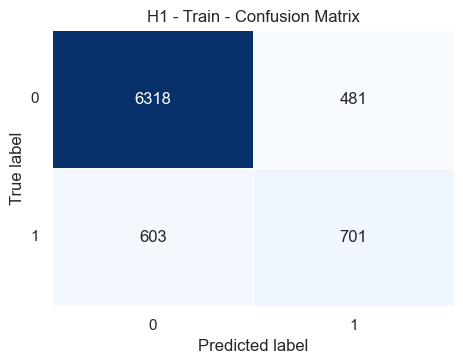


[H1 - Valid] threshold=0.37
Accuracy : 0.8616600790513834
Precision: 0.5632911392405028
Recall   : 0.5562499999999966
F1-score : 0.5597484276724524


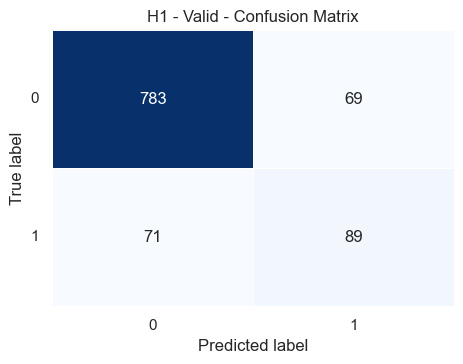


[H1 - Test] threshold=0.37
Accuracy : 0.8685770750988142
Precision: 0.6013513513513473
Recall   : 0.5460122699386469
F1-score : 0.5723472668805264


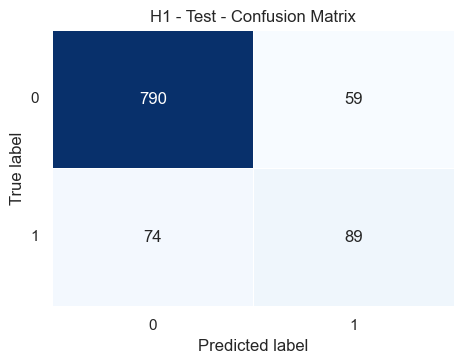

In [14]:
# Đánh giá H1 trên train/valid/test với threshold tốt nhất từ valid
h1_train_metrics = evaluate_binary_classifier(
    model_h1, X_train_h1_s, y_train_h1, threshold=best_threshold_h1, name="H1 - Train"
)

h1_valid_metrics = evaluate_binary_classifier(
    model_h1, X_valid_h1_s, y_valid_h1, threshold=best_threshold_h1, name="H1 - Valid"
)

h1_test_metrics = evaluate_binary_classifier(
    model_h1, X_test_h1_s, y_test_h1, threshold=best_threshold_h1, name="H1 - Test"
)

### Nhận xét kết quả (Hypothesis 1 – Logistic Regression, threshold = 0.37)

#### 1) Tổng quan các chỉ số
- **Train:** Accuracy = 0.8662, Precision = 0.5931, Recall = 0.5376, **F1 = 0.5640**
- **Valid:** Accuracy = 0.8617, Precision = 0.5633, Recall = 0.5563, **F1 = 0.5597**
- **Test:**  Accuracy = 0.8686, Precision = 0.6014, Recall = 0.5460, **F1 = 0.5723**

#### 2) Tính ổn định và khả năng tổng quát hoá
F1-score trên ba tập **dao động trong khoảng 0.5597 → 0.5723** và **khá gần nhau** (Train ≈ Valid ≈ Test).  
Điều này cho thấy mô hình **không có dấu hiệu overfitting rõ rệt**, và hiệu năng trên tập Test **phản ánh khá sát** so với tập Valid.

#### 3) Diễn giải Precision / Recall theo ngưỡng 0.37
Với threshold = 0.37, mô hình đạt:
- **Precision ~ 0.56–0.60:** trong các dự đoán churn (label 1), khoảng 56–60% là đúng.
- **Recall ~ 0.54–0.56:** mô hình bắt được khoảng 54–56% khách hàng churn thật.

Nhìn chung, mô hình đang ở trạng thái **cân bằng tương đối** giữa Precision và Recall (không quá lệch về một phía). 

Điều này có vẻ trái với lo ngại ban đầu của chúng ta khi cho rằng dữ liệu bị lệch sẽ khiến mô hình học lệch.

#### 4) Phân tích từ Confusion Matrix
- **Train:** TN=6318, FP=481, FN=603, TP=701  
- **Valid:** TN=783,  FP=69,  FN=71,  TP=89  
- **Test:**  TN=790,  FP=59,  FN=74,  TP=89  

Trên tập **Test**, số **FN=74** (bỏ sót churn) vẫn tương đối đáng kể so với **TP=89**, cho thấy mô hình còn bỏ sót một phần khách hàng rời bỏ. Đồng thời **FP=59** cho thấy vẫn có một số trường hợp cảnh báo churn nhầm.

#### 5) Kết luận cho Hypothesis 1
- Mô hình Logistic Regression với 3 đặc trưng của H1 cho hiệu năng **mức trung bình**: **F1 ≈ 0.56–0.57**.
- Kết quả **ổn định** giữa Train/Valid/Test → **khả năng tổng quát hoá khá tốt** trong phạm vi dữ liệu hiện tại.
- Tuy nhiên, mô hình vẫn gặp hạn chế khi nhận diện churn: **Recall chỉ ~0.55**, thể hiện qua **FN còn nhiều** (đặc biệt ở Test).

## 2.2. Giả thuyết 2

### Load dữ liệu

In [15]:
# --- Load H2 datasets ---
h2_train_path = "../data/modeling/h2_train.csv"
h2_valid_path = "../data/modeling/h2_valid.csv"
h2_test_path  = "../data/modeling/h2_test.csv"

X_train_h2, y_train_h2, h2_feature_names = load_modeling_csv(h2_train_path)
X_valid_h2, y_valid_h2, _ = load_modeling_csv(h2_valid_path)
X_test_h2,  y_test_h2,  _ = load_modeling_csv(h2_test_path)

print("H2 feature names:", h2_feature_names)
print("Train:", X_train_h2.shape, y_train_h2.shape, "| churn rate:", y_train_h2.mean())
print("Valid:", X_valid_h2.shape, y_valid_h2.shape, "| churn rate:", y_valid_h2.mean())
print("Test : ", X_test_h2.shape,  y_test_h2.shape,  "| churn rate:", y_test_h2.mean())

# check nhanh số feature
print("Số features (H2):", X_train_h2.shape[1])

H2 feature names: ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'Engagement_Score']
Train: (8103, 4) (8103,) | churn rate: 0.16092805133901025
Valid: (1012, 4) (1012,) | churn rate: 0.15810276679841898
Test :  (1012, 4) (1012,) | churn rate: 0.16106719367588934
Số features (H2): 4


### Hyperparameters tuning

In [16]:
# 1) Chuẩn hoá dữ liệu (fit theo train, apply cho valid/test)
X_train_h2_s, X_valid_h2_s, X_test_h2_s, mu_h2, sigma_h2 = standardize_train_valid_test(
    X_train_h2, X_valid_h2, X_test_h2
)

print("Đã chuẩn hoá xong cho H2.")
print("Train mean:", np.mean(X_train_h2_s, axis=0))
print("Train std :", np.std(X_train_h2_s, axis=0))

# 2) Grid search learning rate + threshold theo F1 trên VALID
lr_grid = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
threshold_grid = np.linspace(0.10, 0.90, 81)

best_h2 = {
    "lr": None,
    "threshold": None,
    "f1": -1.0,
    "precision": None,
    "recall": None
}

for lr in lr_grid:
    model = LogisticRegressionNumpy(
        lr=lr,
        n_iters=3000,
        fit_intercept=True,
        reg_lambda=0.0,
        tol=1e-7,
        verbose=False
    )
    model.fit(X_train_h2_s, y_train_h2)

    valid_prob = model.predict_proba(X_valid_h2_s)

    for th in threshold_grid:
        valid_pred = (valid_prob >= th).astype(int)
        p, r, f1 = precision_recall_f1(y_valid_h2, valid_pred)

        if f1 > best_h2["f1"]:
            best_h2["lr"] = lr
            best_h2["threshold"] = float(th)
            best_h2["f1"] = f1
            best_h2["precision"] = p
            best_h2["recall"] = r

print("\nBest hyperparameters cho H2 (theo VALID F1):")
print("- best_lr:", best_h2["lr"])
print("- best_threshold:", best_h2["threshold"])
print("- precision:", best_h2["precision"])
print("- recall   :", best_h2["recall"])
print("- f1       :", best_h2["f1"])

# lưu lại để dùng cho bước Fit + Evaluation
best_lr_h2 = best_h2["lr"]
best_threshold_h2 = best_h2["threshold"]

Đã chuẩn hoá xong cho H2.
Train mean: [-8.86753476e-17 -3.13864420e-17  1.39719848e-16  4.69820406e-17]
Train std : [1. 1. 1. 1.]

Best hyperparameters cho H2 (theo VALID F1):
- best_lr: 0.3
- best_threshold: 0.38
- precision: 0.6023391812865462
- recall   : 0.643749999999996
- f1       : 0.6223564954677747


### Fit mô hình

Best lr (H2): 0.3
Best threshold (H2): 0.38
H2 training done.
Số iter thực tế: 5000
Loss cuối: 0.279700275327201

[H2] Hàm giả thuyết
Gọi x̃_i = (x_i - mu_i) / sigma_i (chuẩn hoá theo train)
z(x) = (-2.765516) + (-2.243656) * x̃_Total_Trans_Ct + (4.833732) * x̃_Total_Trans_Amt + (-0.821339) * x̃_Total_Revolving_Bal + (-4.251716) * x̃_Engagement_Score
p(y=1|x) = sigmoid(z(x))

Chi tiết x̃ theo từng feature:
- x̃_Total_Trans_Ct = (Total_Trans_Ct - 64.765519) / 23.393833
- x̃_Total_Trans_Amt = (Total_Trans_Amt - 4388.372084) / 3380.308353
- x̃_Total_Revolving_Bal = (Total_Revolving_Bal - 1165.408491) / 817.588312
- x̃_Engagement_Score = (Engagement_Score - 348018.398001) / 400172.129537

Trọng số đã học:
- intercept (b) = -2.765516
- w_Total_Trans_Ct = -2.243656
- w_Total_Trans_Amt = 4.833732
- w_Total_Revolving_Bal = -0.821339
- w_Engagement_Score = -4.251716


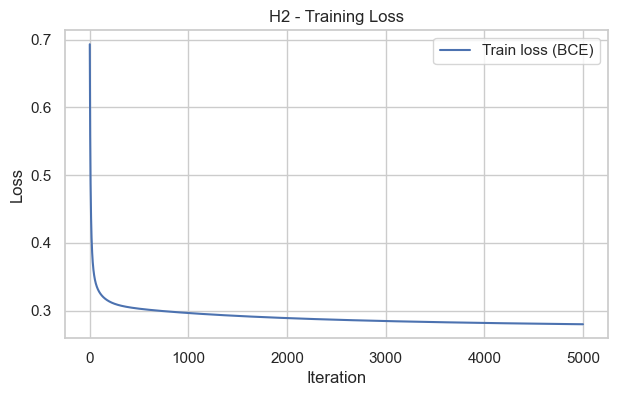

In [20]:
print("Best lr (H2):", best_lr_h2)
print("Best threshold (H2):", best_threshold_h2)

model_h2 = LogisticRegressionNumpy(
    lr=best_lr_h2,
    n_iters=5000,
    fit_intercept=True,
    reg_lambda=0.0,
    tol=1e-7,
    verbose=False
)

model_h2.fit(X_train_h2_s, y_train_h2)

print("H2 training done.")
print("Số iter thực tế:", len(model_h2.loss_history_))
print("Loss cuối:", model_h2.loss_history_[-1])

print_logistic_hypothesis(
    model_h2,
    feature_names=h2_feature_names,
    mu=mu_h2,
    sigma=sigma_h2,
    name="H2"
)

# Vẽ loss history để xem có giảm đều không
plt.figure(figsize=(7, 4))
plt.plot(model_h2.loss_history_, label="Train loss (BCE)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("H2 - Training Loss")
plt.legend()
plt.show()

### Số liệu và đánh giá


[H2 - Train] threshold=0.38
Accuracy : 0.87782302850796
Precision: 0.6255999999999995
Recall   : 0.5996932515337419
F1-score : 0.6123727486291003


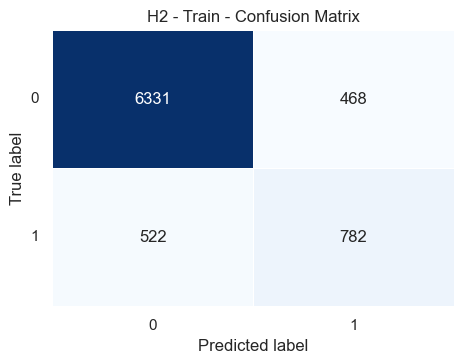


[H2 - Valid] threshold=0.38
Accuracy : 0.8804347826086957
Precision: 0.6127167630057768
Recall   : 0.6624999999999959
F1-score : 0.6366366366361336


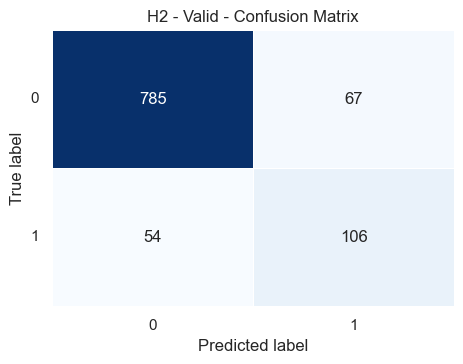


[H2 - Test] threshold=0.38
Accuracy : 0.8853754940711462
Precision: 0.6496815286624162
Recall   : 0.6257668711656403
F1-score : 0.6374999999994961


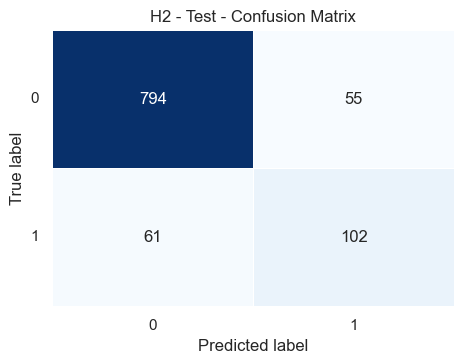


Tóm tắt nhanh (F1):
- H2 Train F1: 0.6123727486291003
- H2 Valid F1: 0.6366366366361336
- H2 Test  F1: 0.6374999999994961


In [21]:
# Đánh giá H2 trên train/valid/test với threshold tốt nhất từ valid
h2_train_metrics = evaluate_binary_classifier(
    model_h2, X_train_h2_s, y_train_h2, threshold=best_threshold_h2, name="H2 - Train"
)

h2_valid_metrics = evaluate_binary_classifier(
    model_h2, X_valid_h2_s, y_valid_h2, threshold=best_threshold_h2, name="H2 - Valid"
)

h2_test_metrics = evaluate_binary_classifier(
    model_h2, X_test_h2_s, y_test_h2, threshold=best_threshold_h2, name="H2 - Test"
)

print("\nTóm tắt nhanh (F1):")
print("- H2 Train F1:", h2_train_metrics["f1"])
print("- H2 Valid F1:", h2_valid_metrics["f1"])
print("- H2 Test  F1:", h2_test_metrics["f1"])

### Nhận xét kết quả (Hypothesis 2 – Logistic Regression, threshold = 0.38)

#### 1) Tổng quan các chỉ số
- **Train:** Accuracy = 0.8778, Precision = 0.6256, Recall = 0.5997, **F1 = 0.6124**
- **Valid:** Accuracy = 0.8804, Precision = 0.6127, Recall = 0.6625, **F1 = 0.6366**
- **Test:**  Accuracy = 0.8854, Precision = 0.6497, Recall = 0.6258, **F1 = 0.6375**

#### 2) Tính ổn định và khả năng tổng quát hoá
F1-score trên ba tập nằm trong khoảng **0.6124 → 0.6375** và **không chênh lệch quá lớn** giữa Valid và Test  
(Valid **0.6366** ≈ Test **0.6375**).  
Điều này cho thấy mô hình H2 **tổng quát hoá tốt** trên dữ liệu chưa thấy.

#### 3) Diễn giải Precision / Recall theo ngưỡng 0.38
Với threshold = 0.38:
- **Precision ~ 0.61–0.65:** trong các dự đoán churn (label 1), khoảng 61–65% là đúng.
- **Recall ~ 0.60–0.66:** mô hình bắt được khoảng 60–66% khách hàng churn thật.

Nhìn chung, H2 đạt sự cân bằng tương đối giữa Precision và Recall, đồng thời Recall trên Valid/Test **khá cao** (≈ 0.626–0.662).

#### 4) Phân tích từ Confusion Matrix
- **Train:** TN=6331, FP=468, FN=522, TP=782  
- **Valid:** TN=785,  FP=67,  FN=54,  TP=106  
- **Test:**  TN=794,  FP=55,  FN=61,  TP=102  

Trên tập **Test**, số **FN=61** (bỏ sót churn) thấp hơn số TP=102, cho thấy mô hình đã bắt được churn tương đối tốt.  
Đồng thời **FP=55** cho thấy vẫn tồn tại các cảnh báo churn nhầm, nhưng ở mức không quá lớn so với tổng mẫu.

#### 5) Kết luận cho Hypothesis 2
- Mô hình Logistic Regression với 4 đặc trưng của H2 cho hiệu năng **tốt hơn mức trung bình**: **F1 ≈ 0.61–0.64**.
- Kết quả Valid và Test **rất gần nhau** (≈ 0.6366 vs 0.6375) → **độ tin cậy** của đánh giá trên test tương đối cao.
- Ở threshold = 0.38, mô hình cho thấy xu hướng **bắt churn tốt hơn** (Recall ~ 0.63 trên test), đồng thời Precision vẫn giữ ở mức **~0.65**.



## 2.3. So sánh, nhận xét hai giả thuyết

### 1) Bối cảnh dữ liệu & thiết lập đánh giá
- Theo notebook 01, dữ liệu bị **mất cân bằng**: **83.93%** là *Existing* và **16.07%** là *Attrited* → vì vậy **F1-score** là thước đo quan trọng hơn Accuracy.
- Trong notebook 03, tỷ lệ churn được in ra cho cả hai giả thuyết là tương đương nhau:
  - **Train churn rate:** 0.16092805133901025  
  - **Valid churn rate:** 0.15810276679841898  
  - **Test churn rate:**  0.16106719367588934
- Ngưỡng phân loại đang dùng:
  - **H1:** threshold = **0.37**
  - **H2:** threshold = **0.38**

---

### 2) Bảng so sánh chỉ số (H1 vs H2)

#### 2.1. Metrics tổng quan (Accuracy / Precision / Recall / F1)
| Dataset | H1 Accuracy | H1 Precision | H1 Recall | H1 F1 | H2 Accuracy | H2 Precision | H2 Recall | H2 F1 |
|---|---:|---:|---:|---:|---:|---:|---:|---:|
| Train | 0.8662 | 0.5931 | 0.5376 | 0.5640 | 0.8778 | 0.6256 | 0.5997 | 0.6124 |
| Valid | 0.8617 | 0.5633 | 0.5563 | 0.5597 | 0.8804 | 0.6127 | 0.6625 | 0.6366 |
| Test  | 0.8686 | 0.6014 | 0.5460 | 0.5723 | 0.8854 | 0.6497 | 0.6258 | 0.6375 |

#### 2.2. Confusion Matrix (TN / FP / FN / TP)
| Dataset | H1 TN | H1 FP | H1 FN | H1 TP | H2 TN | H2 FP | H2 FN | H2 TP |
|---|---:|---:|---:|---:|---:|---:|---:|---:|
| Train | 6318 | 481 | 603 | 701 | 6331 | 468 | 522 | 782 |
| Valid | 783  | 69  | 71  | 89  | 785  | 67  | 54  | 106 |
| Test  | 790  | 59  | 74  | 89  | 794  | 55  | 61  | 102 |

---

### 3) Nhận xét chính

#### 3.1. So sánh theo F1-score 
- **H2 vượt H1 nhất quán trên cả 3 tập**:
  - **Train:** F1 tăng từ **0.5640** → **0.6124** (tăng **0.0484**)
  - **Valid:** F1 tăng từ **0.5597** → **0.6366** (tăng **0.0769**)
  - **Test:**  F1 tăng từ **0.5723** → **0.6375** (tăng **0.0652**)

#### 3.2. H2 bắt churn tốt hơn (Recall cao hơn) và giảm FN rõ rệt
- Trên **Test**:
  - Recall: **0.5460 (H1)** → **0.6258 (H2)**
  - FN: **74 (H1)** → **61 (H2)** (giảm **13** trường hợp bỏ sót churn)
  - TP: **89 (H1)** → **102 (H2)** (tăng **13** trường hợp phát hiện churn đúng)
- Trên **Valid**:
  - Recall: **0.5563 (H1)** → **0.6625 (H2)**
  - FN: **71 (H1)** → **54 (H2)**
  - TP: **89 (H1)** → **106 (H2)**

#### 3.3. H2 không “đánh đổi” bằng việc tăng FP (Precision cũng tăng)
- Trên **Test**:
  - Precision: **0.6014 (H1)** → **0.6497 (H2)**
  - FP: **59 (H1)** → **55 (H2)** (giảm nhẹ)
- Nhìn chung, H2 vừa **giảm FN** (bắt churn tốt hơn) vừa **không làm tăng FP**, nên F1 cải thiện rõ rệt.

---

### 4) Insight & giải thích vì sao H2 có thể tốt hơn H1

#### 4.1. Khác biệt về đặc trưng (feature set) giữa hai giả thuyết
- **H1** sử dụng 3 biến: `Total_Trans_Ct`, `Total_Revolving_Bal`, `Contacts_Count_12_mon`.
- **H2** sử dụng 4 biến: `Total_Trans_Ct`, `Total_Trans_Amt`, `Total_Revolving_Bal`, `Engagement_Score`, trong đó:
  - `Engagement_Score = Total_Trans_Ct * Total_Trans_Amt` (biến tương tác).

#### 4.2. Liên hệ với kết quả tương quan trong notebook 02
Trong notebook 02, các biến liên quan trực tiếp tới hành vi giao dịch và trạng thái tài khoản có tương quan đáng kể với churn (Pearson corr sau encode):
- `Total_Trans_Ct: corr = -0.3573`
- `Total_Revolving_Bal: corr = -0.2654`
- `Contacts_Count_12_mon: corr = 0.1939`
- `Total_Trans_Amt: corr = -0.1604`

=> H2 bổ sung thêm `Total_Trans_Amt` và một biến tương tác từ hai biến giao dịch (`Ct * Amt`), nên mô hình có thêm thông tin để phân biệt churn/non-churn tốt hơn.

#### 4.3. Giả thuyết hợp lý
- **Bổ sung “giá trị giao dịch” (`Total_Trans_Amt`)**: Hai khách hàng có cùng số lần giao dịch (`Total_Trans_Ct`) nhưng tổng tiền giao dịch khác nhau có thể có mức gắn kết khác nhau. H1 không có chiều thông tin này, còn H2 có.
- **Biến tương tác `Engagement_Score` giúp biểu diễn “mức độ gắn kết tổng hợp”**: thay vì chỉ cộng tuyến tính từng biến, mô hình có thể học tín hiệu kết hợp giữa tần suất và giá trị giao dịch. Điều này phù hợp với kết quả thực nghiệm: H2 giảm FN và tăng TP trên Valid/Test.

---

### 5) Kết luận cho phần so sánh
- Với cùng bối cảnh dữ liệu lệch lớp (Existing chiếm đa số), **H2 là giả thuyết tốt hơn** vì đạt F1 cao hơn trên cả Train/Valid/Test (đặc biệt **Valid: 0.6366** và **Test: 0.6375**), đồng thời **giảm FN** (bắt churn tốt hơn) mà **không làm tăng FP**.
- Trong phạm vi bài toán churn, việc giảm FN (bỏ sót khách hàng rời bỏ) thể hiện trực tiếp qua các confusion matrix: **Test FN giảm 74 → 61**, **Valid FN giảm 71 → 54** khi chuyển từ H1 sang H2.